In [8]:
import numpy as np
import random,sys
from collections import defaultdict
import copy
from matplotlib import pyplot as plt

class Node(object):
    def __init__(self):
        self.value = None
        self.right = None
        self.left = None
        self.leaf = False
        self.leaf_list = None

1. Generating Decision Trees


Question 1.1 For a given value of k;m, (number of features, number of data points), write a function to generate a training data set based on the above scheme.


In [9]:
def get_x1():
    return np.random.choice(np.arange(0,2), p=[0.5, 0.5])

def get_x(x):
    return np.random.choice(np.array([x,1-x]), p=[0.75, 0.25])

def get_w(i,k):
    return (0.9**i)/sum([0.9**j for j in range(2,k+1)])

def get_wvalues(k):
    return [ get_w(i,k) for i in range(2,k+1) ]

def get_xvalues(k):
    x_values = np.empty(k,dtype=int)
    x1 = get_x1()
    x_values[0] = x1
    for i in range(1,k):
        x_values[i] = get_x(x_values[i-1])
    return x_values

def get_y(k): 
    x_values = get_xvalues(k)
    w_values = [0] + get_wvalues(k)
    if sum([x*w for x,w in zip(x_values,w_values)]) >= 0.5:
        return x_values[0], x_values
    else:
        return 1-x_values[0], x_values

#data set structure List(List(features+label)). Note: label is last element of the row. 
def create_training_data(k,m):
    y_values = []
    mat = np.empty([m,k+1],dtype=int)
    for i in range(0,m):
        y,x_val = get_y(k)
        y_values.append(y) 
        mat[i,:] = np.append(x_val,y)
    return mat, y_values
    

In [10]:
# #Example of creating data points for k=4 features and m=10 datapoints
data_set, labels = create_training_data(3,5)

In [11]:
print(data_set)
print(labels)

[[1 1 0 1]
 [1 1 0 1]
 [0 0 0 1]
 [0 1 1 0]
 [1 1 1 1]]
[1, 1, 1, 0, 1]


In [12]:
# Question1.2

def get_freq_dist(array):
    #sum of array gives number of rows with label x = 1
    freq_of_one_1 = sum(array) / len(array) #gives probability of x = 1
    freq_of_one = freq_of_one_1 if freq_of_one_1 != 0 else np.finfo(float).eps
    freq_of_zero = 1 - freq_of_one       
    return freq_of_one, freq_of_zero

def cond_prob(column,data):
    col = data[:,column]
    labels = data[:,-1]
    freq_pair = defaultdict(int)
    len_data = len(col)
    freq_one, freq_zero = sum(col), len_data -sum(col)
    for c,l in zip(col,labels):
        if c == 0:
            if freq_zero == 0: #to handle if none of the x value os equal to 0
                    freq_pair[(c,l)] += np.finfo(float).eps
            else:
                freq_pair[(c,l)] += 1/freq_zero
        else:
            if freq_one == 0: #to handle if none of the x value os equal to 0
                    freq_pair[(c,l)] += np.finfo(float).eps
            else:
                freq_pair[(c,l)] += 1/freq_one
    tot_labels = [(1,1),(1,0),(0,0),(0,1)]
    for key in tot_labels: #if key is missing, add a episilon value
        if key not in freq_pair.keys():
            freq_pair[key] = np.finfo(float).eps
    return freq_pair
    
def entropy_y(y_values):
    freq_of_one, freq_of_zero = get_freq_dist(y_values)
    return -freq_of_one*np.log2(freq_of_one)-freq_of_zero*np.log2(freq_of_zero)

def calc_IG(data,y_values,feature_vec):
    entropy_y_all = entropy_y(y_values)
    y_freq_of_one, y_freq_of_zero = get_freq_dist(y_values)
    IG_for_x = []
    for i in range(0,len(feature_vec)):
        freq_of_one, freq_of_zero = get_freq_dist(data[:,i])
        freq_pair = cond_prob(i,data)
        x_0_y_0,x_0_y_1 = freq_pair[(0,0)],freq_pair[(0,1)]
        x_1_y_0,x_1_y_1 = freq_pair[(1,0)],freq_pair[(1,1)]
        ent_x_one  = -x_1_y_1*np.log2(x_1_y_1)-x_1_y_0*np.log2(x_1_y_0)
        ent_x_zero = -x_0_y_1*np.log2(x_0_y_1)-x_0_y_0*np.log2(x_0_y_0)
        entroy_y_x = freq_of_zero*ent_x_zero + freq_of_one*ent_x_one
        IG_for_x.append(entropy_y_all - entroy_y_x)
    max_ig_x = np.argmax(IG_for_x)
    return max_ig_x, IG_for_x[max_ig_x]


In [13]:
# print(data_set)
# calc_IG(data_set,labels,list(range(0,3)))


In [7]:
def decision_tree(data_set, labels, feature_vec):
#     print(labels,"feature vectors before splitting the tree",feature_vec)
    root = Node()
    flag = 0
    if len(list(set(labels))) == 1:
        flag = 1
        root.val = labels[0]
        root.leaf = True
#         print("leaf set is set as True with value",root.val)
        return root
    

    max_ig_ind, maxGain = calc_IG(data_set,labels,feature_vec)
    
#     print("decision tree is splitting on feature",feature_vec[max_ig_ind])
    
    root.val = feature_vec[max_ig_ind]
    if max_ig_ind == 0:
        new_feature_vec = feature_vec[:max_ig_ind]
    else:
        new_feature_vec = feature_vec[max_ig_ind+1:]
#     new_feature_vec = copy.deepcopy(feature_vec)
#     del new_feature_vec[max_ig_ind]
    
    data_right,data_left = data_set[data_set[:,max_ig_ind] !=0],data_set[data_set[:,max_ig_ind] ==0]
    data_right,data_left = np.delete(data_right,max_ig_ind,1),np.delete(data_left,max_ig_ind,1)
#     print("left split data", data_left,"right split data",data_right)
    labels_right,labels_left = data_right[:,-1],data_left[:,-1]
#     root.right,root.left = data_right,data_left
    if len(list(set(labels))) != 1:
        flag = 1
#         print("as all labels not equal continuing splitting",labels)
        new_feature_vec_right = copy.deepcopy(new_feature_vec)
        new_feature_vec_left = copy.deepcopy(new_feature_vec)
        if len(data_right):
            root.right = decision_tree(data_right,labels_right,new_feature_vec_right)
        if len(data_left):
            root.left = decision_tree(data_left,labels_left,new_feature_vec_left)
#     print("\n")
    return root
  

In [8]:
def print_decision_tree(n):
    res = []
    queue = []
    #each level order traversal node is set as (level_of tree, node_val/feature,parent,if its leaf node)
    queue.append((-1, n, None, False))
    h = -1
    while len(queue) >0:
        level = []
        for i in range(len(queue)):    
            h,n,par,leaf = queue.pop(0)
#             print(par,n.leaf)
            level.append((h+1,n.val,par,n.leaf))
            if n.left != None:
                queue.append((h+1, n.left,n.val,n.leaf))
            if n.right != None :
                queue.append((h+1, n.right,n.val,n.leaf))
        res.append(level)
    return res

Question 1. 2:
funtion decision_tree () will generate the decision tree. 
to print the decision tree, use function print_dec_tree with the parameters as first node.

Training error for this decision tree will be 0 since we are not early terminating it. 


Question 1.3

In [9]:
#Question 1.3
k=21
m=10000
data_set_org, labels = create_training_data(k,m)
feature_vec = list(range(0,k)) #taking the values from 0 to k-1 as k-features
# print('data set generated is the following: \n',data_set)
data_set = copy.deepcopy(data_set_org) #just keep old data for testing. can avoid it.
feature_vec = list(range(0,k)) #taking the values from 0 to k-1 as k-features
node_stat = decision_tree(data_set,labels,feature_vec)
node = copy.deepcopy(node_stat)
# print_decision_tree(node)

In [98]:
# t = np.array([[1,1,0,0,0]
# ,[1,0,1,1,1]
# ,[1,1,1,1,1]
# ,[1,1,1,1,1]
# ,[1,1,1,1,1]
# ,[0,0,0,0,1]
# ,[0,0,0,0,1]
# ,[0,0,1,1,0]
# ,[0,1,1,0,0]
# ,[0,0,0,0,1]])
# labels = t[:,-1]
# k,m=4,10
# feature_vec = list(range(0,k))
# # node_test = decision_tree(t,labels,feature_vec)
# # print_decision_tree(node_test)






In [99]:
# calc_IG(t,labels,feature_vec)

In [100]:
# print('data set generated is the following: \n',data_set_org)

Question 1.4

In [171]:
#Q 1.4

#row is the feature vector and node is root of decision tree
# def find_decision(row,node):
#     if node.leaf == True:
#         return node.val
#     while node.leaf != True:
#         feature = node.val
#         if row[feature] == 0:
            
#             node = node.left
#         else:
#             node = node.right
#     return node.val

def get_accuracy(org_dec,pred_dec):
    correct = 0
    for o,p in zip(org_dec,pred_dec):
        if o == p:
            correct += 1
    return correct/len(org_dec)

def get_error(org_dec,pred_dec):
    wrong = 0
    for o,p in zip(org_dec,pred_dec):
        if o != p:
            wrong += 1
    return wrong/len(org_dec)

def get_train_error(data_set,node):
    m = len(data_set)
    predicted_labels = []
    for r in range(0,m):
        predicted_labels.append(find_decision(data_set[r],node))

    return get_error(labels,predicted_labels)

#Generating data miultiple times and getting average error for "i" iterations
def avg_error(i,node_org,k=0):
    error = []
    iterations =  i
    while i:
        node = copy.deepcopy(node_org)
        m=random.randint(10,100)
        if k ==0:
            k = random.randint(2,int(m/4))
        data_set, labels = create_training_data(k,m)
        # print('data set generated is the following: \n',data_set)
        predicted_labels = []
        for r in range(0,m):
#             print(len(data_set[0]))
            predicted_labels.append(find_decision(data_set[r],node))
        
        error.append(get_error(labels,predicted_labels))
        
        i -= 1
    return sum(error)/iterations, error

def find_decision(row,node):
    if node.leaf == True:
        return node.val
    while node.leaf != True:
        
#         if 
        feature = node.val
        if row[feature] == 0:
            if node.left == None:
                return node.val
            node = node.left
        else:
            if node.right == None:
                return node.val
            node = node.right
    return node.val

iterations = 1
avg_error1iter, _= avg_error(iterations,node,k)
print("average error for ",iterations,"iterations is ",avg_error1iter)

average error for  1 iterations is  0.17045454545454544


Question 5

average error for  25 iterations is  0.15636941009614164


Text(0, 0.5, 'Abs error')

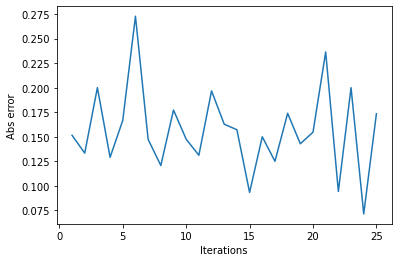

In [172]:
#Question 5
iterations = 25
#passing k=10 features. m is generated randomly in the avg_error function definition
avg_typical_error, typical_errors_list= avg_error(iterations,node,21)
print("average error for ",iterations,"iterations is ",avg_typical_error)
train_data = copy.deepcopy(data_set_org)
training_error = get_train_error(data_set_org,node)

abs_errors = [abs(training_error-te) for te in typical_errors_list]

#plotting the graph for all iterations
plt.plot(list(range(1,iterations+1)),abs_errors)
plt.xlabel("Iterations")
plt.ylabel("Abs error")

Question 1.6

In [173]:
# #I am using gini index instead of information gain

# def calc_gini_index(data_set,labels,feature_vec):
    


# def decision_tree_gini(data_set, labels, feature_vec):
# #     print(labels,"feature vectors before splitting the tree",feature_vec)
#     root = Node()
#     if len(list(set(labels))) == 1:
#         root.val = labels[0]
#         root.leaf = True
# #         print("leaf set is set as True with value",root.val)
#         return root
    
    
    
# #     max_ig_ind, maxGain = calc_IG(data_set,labels,feature_vec)
    
# #     print("decision tree is splitting on feature",feature_vec[max_ig_ind])
    
#     root.val = feature_vec[max_ig_ind]
#     new_feature_vec = copy.deepcopy(feature_vec)
#     del new_feature_vec[max_ig_ind]
    
#     data_right,data_left = data_set[data_set[:,max_ig_ind] !=0],data_set[data_set[:,max_ig_ind] ==0]
#     data_right,data_left = np.delete(data_right,max_ig_ind,1),np.delete(data_left,max_ig_ind,1)
# #     print("left split data", data_left,"right split data",data_right)
#     labels_right,labels_left = data_right[:,-1],data_left[:,-1]
#     root.right,root.left = data_right,data_left
#     if len(list(set(labels))) != 1:
# #         print("as all labels not equal continuing splitting",labels)
#         new_feature_vec_right = copy.deepcopy(new_feature_vec)
#         new_feature_vec_left = copy.deepcopy(new_feature_vec)
#         if len(data_right):
#             root.right = decision_tree(data_right,labels_right,new_feature_vec_right)
#         if len(data_left):
#             root.left = decision_tree(data_left,labels_left,new_feature_vec_left)
# #     print("\n")
#     return root

Question2:

Question2.1

In [177]:
def get_x1_2():
    return np.random.choice(np.arange(0,2), p=[0.5, 0.5])

def get_x_2(x):
    return np.random.choice(np.array([x,1-x]), p=[0.75, 0.25])

def get_xvalues_2(k):
    x_values = np.empty(k,dtype=int)
    x1 = get_x1_2()
    x_values[0] = x1
    for i in range(1,15):
        x_values[i] = get_x_2(x_values[i-1])
    for i in range(15,21):
        x_values[i] = get_x1_2()
    return x_values

def get_y_2(k): 
    x_values = get_xvalues_2(k)
    if x_values[0] == 0:
        sum_1_7 = sum(x_values[1:7])
        rev_sum_1_7 = 7 - sum_1_7
        if sum_1_7 > rev_sum_1_7:
            return 1, x_values
        else:
            return 0,x_values
    else:
        sum_8_14 = sum(x_values[8:14])
        rev_sum_8_14 = 7 - sum_8_14
        if sum_8_14 > rev_sum_8_14:
            return 1, x_values
        else:
            return 0,x_values

#data set structure List(List(features+label)). Note: label is last element of the row. 
def create_training_data_2(k,m):
    y_values = []
    mat = np.empty([m,k+1],dtype=int)
    for i in range(0,m):
        y,x_val = get_y_2(k)
        y_values.append(y) 
        mat[i,:] = np.append(x_val,y)
    return mat, y_values


def decision_tree_2(data_set, labels, feature_vec,irr_var=[]):
#     print(labels,"feature vectors before splitting the tree",feature_vec)
    root = Node()
    if len(list(set(labels))) == 1:
        root.val = labels[0]
        root.leaf = True
#         print("leaf set is set as True with value",root.val)
        return root,irr_var
    

    max_ig_ind, maxGain = calc_IG(data_set,labels,feature_vec)
    if feature_vec[max_ig_ind] in range(15,21):
        irr_var.append(feature_vec[max_ig_ind])
    
#     print("decision tree is splitting on feature",feature_vec[max_ig_ind])
    
    root.val = feature_vec[max_ig_ind]
    new_feature_vec = copy.deepcopy(feature_vec)
    del new_feature_vec[max_ig_ind]
    
    data_right,data_left = data_set[data_set[:,max_ig_ind] !=0],data_set[data_set[:,max_ig_ind] ==0]
    data_right,data_left = np.delete(data_right,max_ig_ind,1),np.delete(data_left,max_ig_ind,1)
#     print("left split data", data_left,"right split data",data_right)
    labels_right,labels_left = data_right[:,-1],data_left[:,-1]
#     root.right,root.left = data_right,data_left
    if len(list(set(labels))) != 1:
#         print("as all labels not equal continuing splitting",labels)
        new_feature_vec_right = copy.deepcopy(new_feature_vec)
        new_feature_vec_left = copy.deepcopy(new_feature_vec)
        if len(data_right):
            root.right,_ = decision_tree_2(data_right,labels_right,new_feature_vec_right,irr_var)
        if len(data_left):
            root.left,_ = decision_tree_2(data_left,labels_left,new_feature_vec_left,irr_var)
#     print("\n")
    return root,irr_var


m_2 = 10000
k=21
#Creating the data
data_set_org_2,labels_2 = create_training_data_2(21,m_2)
feature_vec_2 = list(range(0,k)) #taking the values from 0 to k-1 as k-features
# print('data set generated is the following: \n',data_set)
data_set_2 = copy.deepcopy(data_set_org_2) #just keep old data for testing. can avoid it.
#Function tofit the tree using ID3
node_stat_2,irr_var = decision_tree_2(data_set_2,labels_2,feature_vec_2)
node_2 = copy.deepcopy(node_stat_2)
#printing the decision tree
printer_dt = print_decision_tree(node_2)
# print(dt)




In [178]:
def avg_error_2(i,node_org,k=21):
    error = []
    iterations = i
    while i:
        node = copy.deepcopy(node_org)
        m=random.randint(50,1000)
        data_set, labels = create_training_data_2(k,m)
        # print('data set generated is the following: \n',data_set)
        predicted_labels = []
        for r in range(0,m):
#             print(len(data_set[0]))
            predicted_labels.append(find_decision(data_set[r],node))
        
        error.append(get_error(labels,predicted_labels))
        
        i -= 1
    return sum(error)/iterations, error


In [180]:
# node_2_err = copy.deepcopy(node_stat_2)
avg_error_2(20,node_stat_2)

(0.08185190327023104,
 [0.09798657718120805,
  0.09784735812133072,
  0.07506053268765134,
  0.05343511450381679,
  0.10858585858585859,
  0.07467532467532467,
  0.08108108108108109,
  0.07713498622589532,
  0.07643312101910828,
  0.07385524372230429,
  0.09475806451612903,
  0.08441558441558442,
  0.08387799564270153,
  0.0737618545837724,
  0.06826568265682657,
  0.08227848101265822,
  0.07894736842105263,
  0.06870229007633588,
  0.09673366834170855,
  0.0892018779342723])

In [69]:
#Generating data miultiple times and getting average error for "i" iterations
def avg_error_2(i,node,k=0):
    print(node.leaf)
    error = []
    iterations =  i
#     node_p = copy.deepcopy(node_org)
#     t = print_decision_tree(node_p)
#     print(t)
    while i:
#         node = copy.deepcopy(node_org)
        m=99
        if k ==0:
            k = random.randint(2,int(m/4))
        data_set, labels = create_training_data_2(k,m)
        # print('data set generated is the following: \n',data_set)
        predicted_labels = []
        for r in range(0,m):
            print("gere",type(node))
            predicted_labels.append(find_decision_2(data_set[r],node))
        
        error.append(get_error(labels,predicted_labels))
        
        i -= 1
    return sum(error)/iterations, error

#row is the feature vector and node is root of decision tree
def find_decision_2(row,node):
    
    while node.leaf != True:
        feature = node.val
        if row[feature] == 0:
            node = node.left
            print(type(node.leaf),"datatype")
        else:
            print(type(node.right),"datatype")
            node = node.right
    return node.val

In [70]:

iterations = 2
#passing k=10 features. m is generated randomly in the avg_error function definition
node_2 = copy.deepcopy(node_stat_2)
avg_typical_error, typical_errors_list= avg_error_2(iterations,node_2,k=21)
# print("average error for ",iterations,"iterations is ",avg_typical_error)
# #get train error rate
# node_2_copy = copy.deepcopy(node_stat_2)
# training_error = get_train_error(data_set_org_2,node_2)
# abs_errors = [abs(training_error-te) for te in typical_errors_list]

# #plotting the graph for all iterations
# plt.plot(list(range(1,iterations+1)),abs_errors)
# plt.xlabel("Iterations")
# plt.ylabel("Abs error")


# #Does this agree with intuition
# # It does not go with the intution. By experiments, we can see that if the data is sufficiently small, 
# # sometiems irrelevant variables are picked as decision variables

False
gere <class '__main__.Node'>
<class 'bool'> datatype
<class 'bool'> datatype
<class 'bool'> datatype
<class 'bool'> datatype
<class 'bool'> datatype
<class 'bool'> datatype
<class 'bool'> datatype
<class 'bool'> datatype
gere <class '__main__.Node'>
<class 'bool'> datatype
<class 'bool'> datatype
<class '__main__.Node'> datatype
<class 'bool'> datatype
<class 'bool'> datatype
<class 'bool'> datatype
<class '__main__.Node'> datatype
<class 'bool'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class 'bool'> datatype
<class 'bool'> datatype
gere <class '__main__.Node'>
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> data

<class '__main__.Node'> datatype
<class 'bool'> datatype
<class 'bool'> datatype
<class 'bool'> datatype
gere <class '__main__.Node'>
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class 'bool'> datatype
<class 'bool'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class 'bool'> datatype
<class 'bool'> datatype
<class 'bool'> datatype
gere <class '__main__.Node'>
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class 'bool'> datatype
<class '__main__.Node'> datatype
<class 'bool'> datatype
<class '__main__.Node'> datatype
gere <class '__main__.Node'>
<class 'bool'> datatype
<class '__main__.Node'> datatype
<class 'bool'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class 'bool'> datatype
<class 'bool'> datatype
<class 'bool'> datatype
gere <class '__main__.Nod

<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class 'bool'> datatype
<class '__main__.Node'> datatype
<class 'bool'> datatype
<class '__main__.Node'> datatype
gere <class '__main__.Node'>
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class 'bool'> datatype
<class '__main__.Node'> datatype
gere <class '__main__.Node'>
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class 'bool'> datatype
<class 'bool'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
gere <class '__main__.Node'>
<class '__main__.Node'> datatype
<class '__main__.Node'> datatype
<class 'bool'> datatype
<class '__main__.Node'> datatype
<class '__

AttributeError: 'numpy.ndarray' object has no attribute 'leaf'

Question 2.2

In [ ]:
print("irrelavant data", set(irr_var)) #Used decesion_tree_2 to get irrelevant variables

Question 2.3.a

In [74]:
def decision_tree_depth_prune(data_set, labels, feature_vec,depth,d=0):
#     print(labels,"feature vectors before splitting the tree",feature_vec)
    root = Node()
    if len(list(set(labels))) == 1 or d == depth:
        sum_labels =  sum(labels)
        rev_labels = len(labels) - sum_labels
        if sum_labels > rev_labels:
            root.val = 1
        else:
            roo.val = 0
        root.leaf = True
#         print("leaf set is set as True with value",root.val)
        return root
    

    max_ig_ind, maxGain = calc_IG(data_set,labels,feature_vec)
    
#     print("decision tree is splitting on feature",feature_vec[max_ig_ind])
    
    root.val = feature_vec[max_ig_ind]
    new_feature_vec = copy.deepcopy(feature_vec)
    del new_feature_vec[max_ig_ind]
    
    data_right,data_left = data_set[data_set[:,max_ig_ind] !=0],data_set[data_set[:,max_ig_ind] ==0]
    data_right,data_left = np.delete(data_right,max_ig_ind,1),np.delete(data_left,max_ig_ind,1)
#     print("left split data", data_left,"right split data",data_right)
    labels_right,labels_left = data_right[:,-1],data_left[:,-1]
    root.right,root.left = data_right,data_left
    if len(list(set(labels))) != 1:
#         print("as all labels not equal continuing splitting",labels)
        new_feature_vec_right = copy.deepcopy(new_feature_vec)
        new_feature_vec_left = copy.deepcopy(new_feature_vec)
        if len(data_right):
            root.right = decision_tree_depth_prune(data_right,labels_right,new_feature_vec_right,d+1,depth)
        if len(data_left):
            root.left = decision_tree_depth_prune(data_left,labels_left,new_feature_vec_left,d+1,depth)
#     print("\n")
    return root
        

  

SyntaxError: non-default argument follows default argument (<ipython-input-74-50e24acd4d08>, line 1)

Question 2.3.b

In [88]:
def decision_tree_sample_size(data_set, labels, feature_vec,sample_size):
#     print(labels,"feature vectors before splitting the tree",feature_vec)
    root = Node()
    if len(list(set(labels))) == 1 or len(labels) == sample_size:
        root.val = labels[0]
        root.leaf = True
        sum_labels =  sum(labels)
        rev_labels = len(labels) - sum_labels
        if sum_labels > rev_labels:
            root.val = 1
        else:
            roo.val = 0
#         print("leaf set is set as True with value",root.val)
        return root
    

    max_ig_ind, maxGain = calc_IG(data_set,labels,feature_vec)
    
#     print("decision tree is splitting on feature",feature_vec[max_ig_ind])
    
    root.val = feature_vec[max_ig_ind]
    new_feature_vec = copy.deepcopy(feature_vec)
    del new_feature_vec[max_ig_ind]
    
    data_right,data_left = data_set[data_set[:,max_ig_ind] !=0],data_set[data_set[:,max_ig_ind] ==0]
    data_right,data_left = np.delete(data_right,max_ig_ind,1),np.delete(data_left,max_ig_ind,1)
#     print("left split data", data_left,"right split data",data_right)
    labels_right,labels_left = data_right[:,-1],data_left[:,-1]
    root.right,root.left = data_right,data_left
    if len(list(set(labels))) != 1:
#         print("as all labels not equal continuing splitting",labels)
        new_feature_vec_right = copy.deepcopy(new_feature_vec)
        new_feature_vec_left = copy.deepcopy(new_feature_vec)
        if len(data_right):
            root.right = decision_tree_sample_size(data_right,labels_right,new_feature_vec_right,sample_size)
        if len(data_left):
            root.left = decision_tree_sample_size(data_left,labels_left,new_feature_vec_left,sample_size)
#     print("\n")
    return root
        
    
  

In [ ]:
# # data = [[0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1]
# #  [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0]
# #  [0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1]
# #  [0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1]
# #  [1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0]
# #  [1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1]
# #  [0, 0, 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1]
# #  [1, 1, 1 0 0 0 1 1 1 1 0 0 1 1 0 1 1 0 0 0 1 1]
# #  [0, 1, 0 0 1 1 1 0 0 1 0 0 0 0 0 1 1 0 1 0 1 1]
# #  [1, 1, 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 0 1 1]]

# data_test = np.array([[0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0]
# ,[0,0,0,0,1,1,1,1,0,0,0,0,0,0,0,1,1,0,1,1,0,1]
# ,[0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,1,0,1,0,1,0]
# ,[1,0,0,1,0,0,0,0,0,0,0,1,1,1,1,1,1,1,0,1,1,1]
# ,[0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0]
# ,[0,0,0,0,1,1,1,1,1,1,0,0,0,1,1,1,0,0,1,0,1,1]
# ,[0,0,1,1,1,1,0,1,1,1,1,1,1,1,1,0,0,1,0,0,1,1]
# ,[0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,0,0,1,1,1,0]
# ,[1,1,0,0,0,0,0,0,0,0,1,0,1,1,1,0,1,0,0,1,1,1]
# ,[0,0,0,0,0,1,1,1,0,0,0,0,0,1,1,0,0,1,1,1,1,0]])

# labels_2 = data_test[:,-1]
# labels_2
# feature_vec_2 = list(range(0,k))
# t = decision_tree(data_set_2,labels_2,feature_vec_2)
# print_decision_tree(t)